# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [2]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [3]:
!pip install sentencepiece

In [4]:
import torch
import numpy as np
from dataset import TextDataset

In [5]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [6]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [7]:
from model import LanguageModel

In [8]:
model = LanguageModel(train_set)

In [9]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

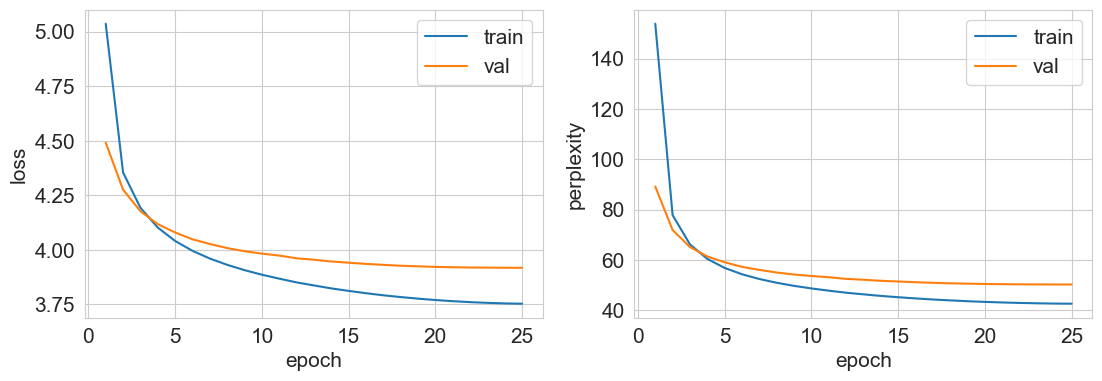

Generation examples:
- вчера патрона агента биллы была интернета, масло возьми вернем куда-нибудь книгу?- нет никака не поднять об стену. для чего вилка тоже рассказы, пока ты гохает.
слушал к истории уши отхлотит. ночика картошку!
он уже настолько длинный, упадет мы изнально делаю не с чучело. выпью раньше - красиво.
майсу - это долил. на всякий случай сбежались и мы ее пела не обнаруженно.
аспискатель да и зовут анном что-то подругают!- ой, ну вот, бы нам нет.


In [9]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from train import train
from torch.utils.data import DataLoader

device = torch.device('mps')
model = model.to(device)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

In [12]:
torch.save(model, 'model1.pt')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

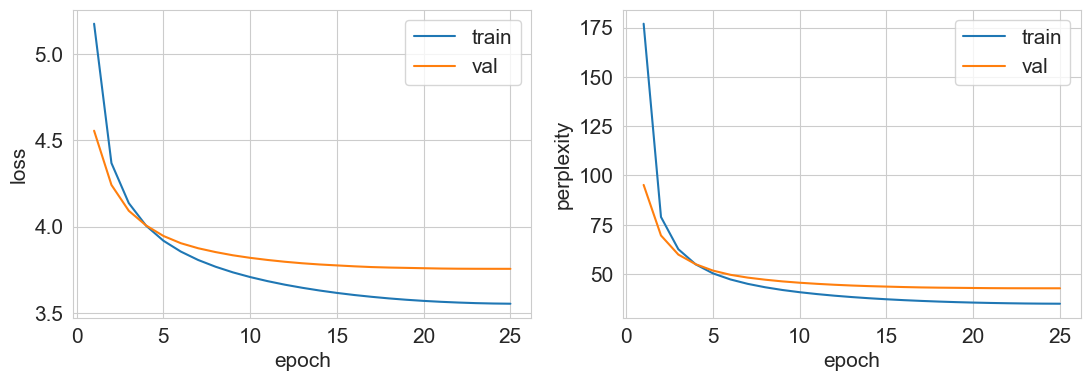

Generation examples:
спать у а нам сегодня аварии пособие наличие моих сорок лет - с вами по  ⁇ 2 кг знает, чем же вперед как берут!
эффектнее угодников - похоже.
руководству- внука, мне сказали, что я себе позволяю, но она просятла, как снег, который попал васила чешся.
душу после за теми, что я пришла кожую.
ждала  ⁇  чемпионате, если женишься на проценты в доме, то смотрели под себя тебе и вашу гламуще!


In [13]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from torch import nn
from train import train
from torch.utils.data import DataLoader

device = torch.device('mps')
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 25
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

In [14]:
torch.save(model, 'model2.pt')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [25]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    for temp in np.logspace(-2, 1, 10):
        generated = model.inference(prefix, temp=temp)
        print(f"Prefix=\"{prefix}\", Temp={temp}:\n", generated)

Prefix="", Temp=0.01:
 - а ты знаешь, что я не могу, чтобы ты не знаешь, что я нашел на работу?- да, но я не могу понять, что я не могу, а я не знаю, что я не могу.
Prefix="", Temp=0.021544346900318832:
 - а что это у тебя в школе?- а я не знаю, что я не могу, а я не знаю, что я не могу, а я не знаю, что я не могу.
Prefix="", Temp=0.046415888336127774:
 - а ты знаешь, что я не могу, чтобы ты не знаешь, что я нашел на работу?- да, но я не могу понять, что я не могу, а я не могу, чтобы не выбраться.
Prefix="", Temp=0.1:
 - а ты знаешь, что у вас есть?- нет, я не могу, а я не могу, а я не знаю, что я не могу.
Prefix="", Temp=0.21544346900318834:
 - а что это у вас в квартире?- да вот, в каком-то смысле, а я не знаю, что я не могу, а я не могу, а я не знаю, что я нашел.
Prefix="", Temp=0.46415888336127775:
 - дорогой, ты слышал, что я вам не любил?- да я хочу, как ты мог бы стать, когда я прихожу домой, так как ты мне в школе.
Prefix="", Temp=1.0:
 куда рассыпьют восемь нового года собрала

Вообще, чем больше температура, тем дичёвей получаются фразочки.

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [9]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe4000', vocab_size=4000)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe4000', vocab_size=4000)

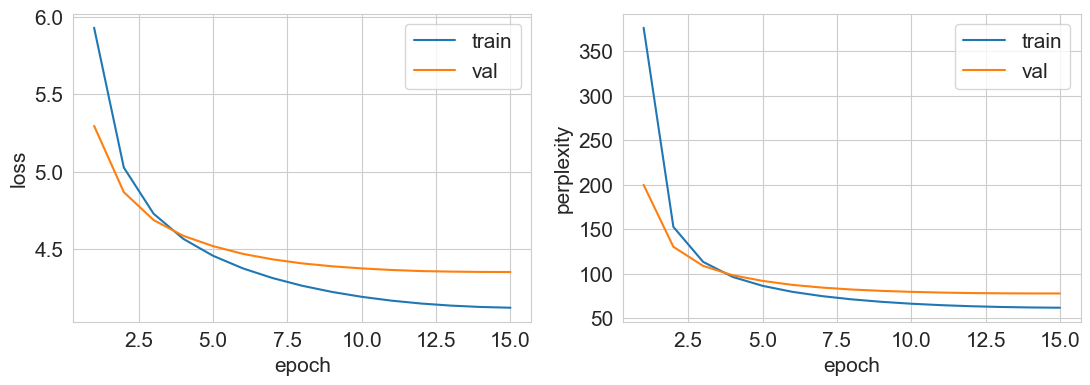

Generation examples:
- мама, а правда андрееха сказано...- почему?- в этом месте отпускаются, как профессиональные убийца.
чтобы помнить полицейский мужчину не любит, а в вашем урале не свет.
проблемы с коррупцией в городской семье страны? это пальцем. а есть есть? аптют останется минуту, а мы отцом, чтобы не попали!
один знакомый пришел после работы в клубе с невестом в костюм магазине.но секрет когда жена спрашивает- сколько мой?- судя по старинию по бабе!
- сегодня я хотел бы расстаться своей лошади, продавщики и сказала, что там все время кладутся.


In [10]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from torch import nn
from train import train
from torch.utils.data import DataLoader

device = torch.device('mps')
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(valid_set, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

In [11]:
torch.save(model, 'model3.pt')

In [14]:
for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    for temp in np.logspace(-2, 1, 10):
        generated = model.inference(prefix, temp=temp)
        print(f"Prefix=\"{prefix}\", Temp={temp}:\n", generated)

Prefix="", Temp=0.01:
 - а ты знаешь, что такое любовь?- да, конечно, но не знаю, но я не знаю, что я не могу.
Prefix="", Temp=0.021544346900318832:
 - а ты знаешь, что такое любовь?- да, конечно, но не знаю, что я не могу.
Prefix="", Temp=0.046415888336127774:
 - а ты знаешь, что такое в мире?- да, но я не знаю, что я не могу.
Prefix="", Temp=0.1:
 - а я вчера на работу в школе не могу, но я не могу понять, что я не могу.- а что, если вы не хотите, чтобы я не могу понять, что вы не можете сказать, что я не могу?
Prefix="", Temp=0.21544346900318834:
 - ты знаешь, что такое в мире?- да, но я не могу сказать, что я не могу.
Prefix="", Temp=0.46415888336127775:
 - я не знаю, что такое благотворительное, но с тобой - я тоже.
Prefix="", Temp=1.0:
 жизнь умер, если машино есть до дома, надо его тянуться в заднем нас.
Prefix="", Temp=2.154434690031882:
 пьяный играстныйсаешься похо.зя изна сверху за унижемческие пред увоником хирурнер?- конечно они живет холодильник!. подзерчка во дерев девож

In [10]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')

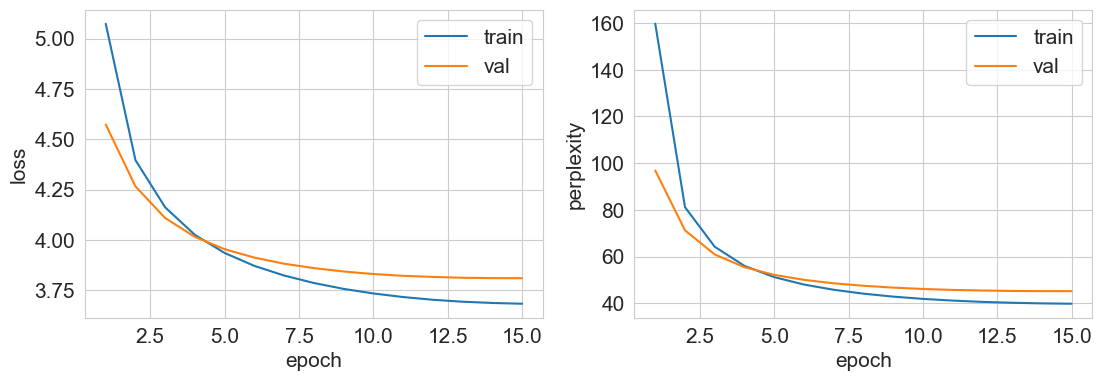

Generation examples:
- мама! куда-то русские.- слушай, она вот повесил растворные!- не знаю, нулека!- тогда хорошее...
старующий человек разговаривают китайцы выдерживать сказку поразиться кирпичом, а брюляют результаты.
в жизни не жизнь, а тем более толпы, потому, что от льство пробок... их - акцию.
- я вы пьянки сегодня вечером приготовь к женщине- а почему он после квартира делал?- конечно.- да или тебе дашь?
штирлиц сегодня в рекламный чай с рукой приборщики только не открываться.так в оружи.


In [11]:
from torch import nn
from train import train
from torch.utils.data import DataLoader

device = torch.device('mps')
model = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 15
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

train(model, optimizer, scheduler, train_loader, test_loader, num_epochs)

In [12]:
torch.save(model, 'model4.pt')

In [13]:
for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    for temp in np.logspace(-2, 1, 10):
        generated = model.inference(prefix, temp=temp)
        print(f"Prefix=\"{prefix}\", Temp={temp}:\n", generated)

Prefix="", Temp=0.01:
 - а что такое у вас есть?- нет, я не могу, я не могу, я не могу, я не могу, я не могу.
Prefix="", Temp=0.021544346900318832:
 - а что такое у вас есть?- да, но я не могу понять, что я не могу, я не могу, я не могу.
Prefix="", Temp=0.046415888336127774:
 - а я вчера в магазине- я не могу, я не могу, я не могу, я не могу, я не могу, я не могу, я не могу, я не могу, я не могу, я не могу, я не могу, я не могу.
Prefix="", Temp=0.1:
 - а ты знаешь, что у вас в школе?- да, а что, если бы ты не знаешь, что я не могу, я не могу, я не могу, я не могу, я не могу.
Prefix="", Temp=0.21544346900318834:
 - а что такое у вас есть?- да, но я не могу снять, что я не могу.
Prefix="", Temp=0.46415888336127775:
 - ты что, надежная ситуация?- да, но я не знаю, что я не знаю, но у тебя несет.
Prefix="", Temp=1.0:
 - а скорей решать ни каплион, если у тебя ходишь чего?- никакой туже.
Prefix="", Temp=2.154434690031882:
 глядя смотреть россии в аймут отрочно прелюманания сидя обязан одинд

Ну, наверное сравнвать их между собой неправильно, всё таки токенизаторы разные. Но вообще все модели дичёвые получились, поэтому без разницы. 

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [15]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

def LCA(model: LanguageModel, valid_set: TextDataset):
    sample = []
    for tokens, length in valid_set:
        sample.append(valid_set.ids2text(tokens[:length]))
    model.eval()
    for _ in range(len(valid_set)):
        sample.append(model.inference())
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(sample)
    svd = TruncatedSVD(n_components=100)
    reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)
    val_reduced_matrix = reduced_tfidf_matrix[:len(valid_set)]
    gen_reduced_matrix = reduced_tfidf_matrix[len(valid_set):]
    similarities = []
    for i in range(len(valid_set)):
        sim_scores = cosine_similarity(gen_reduced_matrix[i].reshape(1, -1), val_reduced_matrix)[0]
        max_sim = np.max(sim_scores)
        similarities.append(max_sim)
    avg_similarity = np.mean(similarities)
    return val_reduced_matrix, gen_reduced_matrix, avg_similarity

In [27]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model: LanguageModel = torch.load('model1.pt')
d = model.state_dict()
model = LanguageModel(valid_set).to(device)
model.load_state_dict(d)
val_reduced_matrix_1, gen_reduced_matrix_1, lca = LCA(model, valid_set)
lca

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_48238/2337463250.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model1.pt'

0.7272635793236578

In [30]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model: LanguageModel = torch.load('model2.pt')
d = model.state_dict()
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(d)
val_reduced_matrix_2, gen_reduced_matrix_2, lca = LCA(model, valid_set)
lca

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_48238/1358260834.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model2.pt'

0.721680463193513

In [31]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe4000', vocab_size=4000)
model: LanguageModel = torch.load('model3.pt')
d = model.state_dict()
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(d)
val_reduced_matrix_3, gen_reduced_matrix_3, lca = LCA(model, valid_set)
lca

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_48238/3569763608.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model3.pt'

0.7241849089482553

In [16]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')
model: LanguageModel = torch.load('model4.pt')
d = model.state_dict()
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(d)
val_reduced_matrix_4, gen_reduced_matrix_4, lca = LCA(model, valid_set)
lca

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_63165/3183165443.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model4.pt'

0.7263138045216143

Ну из плюсов думаю, что простота реализации и наверное учёт семантического сходства. А из минусов наверное то, что она не уситывает структуры текста и зависит от размера выборки. 

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

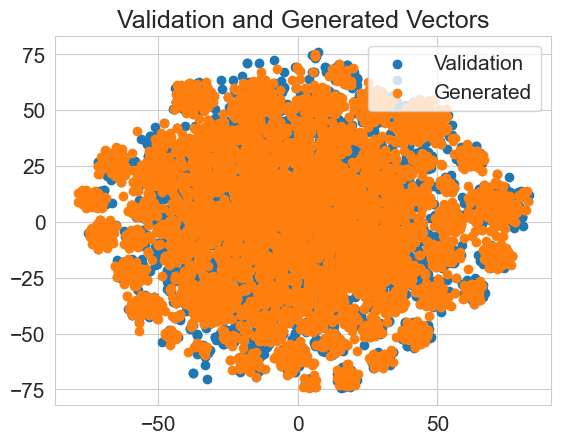

In [32]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
combined_vectors = np.vstack((val_reduced_matrix_1, gen_reduced_matrix_1))
reduced_vectors = tsne.fit_transform(combined_vectors)

val_reduced = reduced_vectors[:len(val_reduced_matrix_1)]
gen_reduced = reduced_vectors[len(val_reduced_matrix_1):]

plt.scatter(val_reduced[:, 0], val_reduced[:, 1], label='Validation')
plt.scatter(gen_reduced[:, 0], gen_reduced[:, 1], label='Generated')
plt.title('Validation and Generated Vectors')
plt.legend()
plt.show()

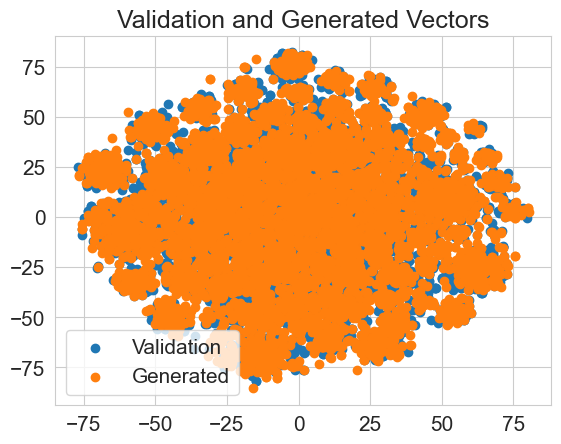

In [33]:
tsne = TSNE(n_components=2)
combined_vectors = np.vstack((val_reduced_matrix_2, gen_reduced_matrix_2))
reduced_vectors = tsne.fit_transform(combined_vectors)

val_reduced = reduced_vectors[:len(val_reduced_matrix_1)]
gen_reduced = reduced_vectors[len(val_reduced_matrix_1):]

plt.scatter(val_reduced[:, 0], val_reduced[:, 1], label='Validation')
plt.scatter(gen_reduced[:, 0], gen_reduced[:, 1], label='Generated')
plt.title('Validation and Generated Vectors')
plt.legend()
plt.show()

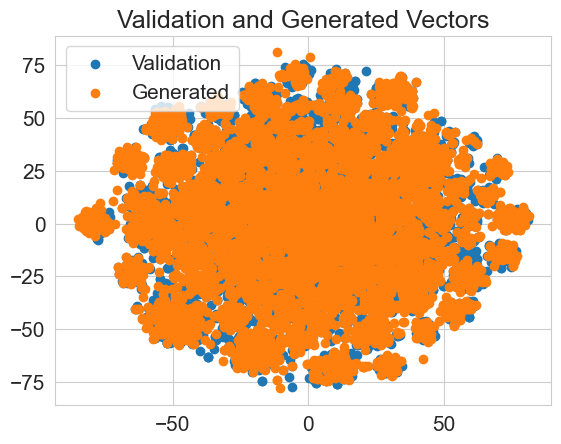

In [34]:
tsne = TSNE(n_components=2)
combined_vectors = np.vstack((val_reduced_matrix_3, gen_reduced_matrix_3))
reduced_vectors = tsne.fit_transform(combined_vectors)

val_reduced = reduced_vectors[:len(val_reduced_matrix_1)]
gen_reduced = reduced_vectors[len(val_reduced_matrix_1):]

plt.scatter(val_reduced[:, 0], val_reduced[:, 1], label='Validation')
plt.scatter(gen_reduced[:, 0], gen_reduced[:, 1], label='Generated')
plt.title('Validation and Generated Vectors')
plt.legend()
plt.show()

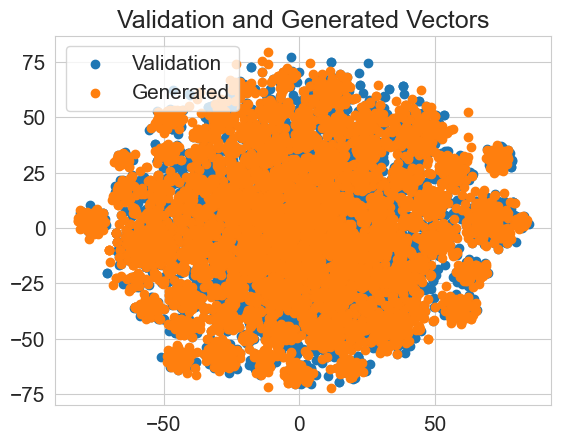

In [20]:
tsne = TSNE(n_components=2)
combined_vectors = np.vstack((val_reduced_matrix_4, gen_reduced_matrix_4))
reduced_vectors = tsne.fit_transform(combined_vectors)

val_reduced = reduced_vectors[:len(val_reduced_matrix_4)]
gen_reduced = reduced_vectors[len(val_reduced_matrix_4):]

plt.scatter(val_reduced[:, 0], val_reduced[:, 1], label='Validation')
plt.scatter(gen_reduced[:, 0], gen_reduced[:, 1], label='Generated')
plt.title('Validation and Generated Vectors')
plt.legend()
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [21]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = torch.device('mps')
model_id = "ai-forever/rugpt3small_based_on_gpt2"
gpt3small = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)


In [22]:
from tqdm import tqdm

def f(model: LanguageModel):
    encodings = tokenizer("\n\n".join([model.inference() for _ in tqdm(range(1024))]), return_tensors="pt")
    max_length = gpt3small.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc 
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = gpt3small(input_ids, labels=target_ids)
            neg_log_likelihood = outputs.loss

        num_valid_tokens = (target_ids != -100).sum().item() 
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size 
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
        
    avg_nll = nll_sum / n_tokens
    return torch.exp(avg_nll).item()

In [23]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model: LanguageModel = torch.load('model1.pt')
d = model.state_dict()
model = LanguageModel(valid_set).to(device)
model.load_state_dict(d)
f(model)

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_13814/3652738953.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model1.pt'

570.9332885742188

In [24]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')
model: LanguageModel = torch.load('model2.pt')
d = model.state_dict()
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(d)
f(model)

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_13814/3202842615.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model2.pt'

500.4627990722656

In [25]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe4000', vocab_size=4000)
model: LanguageModel = torch.load('model3.pt')
d = model.state_dict()
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(d)
f(model)

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_13814/747428224.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model3.pt')

500.40814208984375

In [26]:
device = torch.device('mps')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram')
model: LanguageModel = torch.load('model4.pt')
d = model.state_dict()
model = LanguageModel(valid_set, rnn_type=torch.nn.LSTM).to(device)
model.load_state_dict(d)
f(model)

/var/folders/yl/bg_6c7_56kl413fpblgzt_5w0000gn/T/ipykernel_13814/3451007011.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: LanguageModel = torch.load('model4.pt'

543.7323608398438

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

\- батюшка, мне кажется, свинка, дай мне штаны.\- а ты что? ты уже там делал?